In [125]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tskit
import tsinfer

print(f"tskit {tskit.__version__}")
print(f"tsinfer {tsinfer.__version__}")

tskit 0.5.3
tsinfer 0.2.4.dev57+gde277cf


### Load data

In [126]:
base_dir = Path("/Users/szhan/Projects/tsimpute")
ts_file = base_dir / "analysis" / "test" / "test.inferred.trees"

In [127]:
ts = tskit.load(ts_file)
ts

### Examine the correlation between edge span and edge time

In [128]:
edge_spans = ts.edges_right - ts.edges_left
edge_parent_times = ts.nodes_time[ts.edges_parent]
edge_child_times = ts.nodes_time[ts.edges_child]

if edge_spans[-1] == ts.sequence_length:
    edge_spans = edge_spans[:-2]
    edge_parent_times = edge_parent_times[:-2]
    edge_child_times = edge_child_times[:-2]

edge_spans = edge_spans / 1e6

df_edges = pd.DataFrame({
    'edge_spans': edge_spans,
    'edge_parent_times': edge_parent_times,
    'edge_child_times': edge_child_times,
})

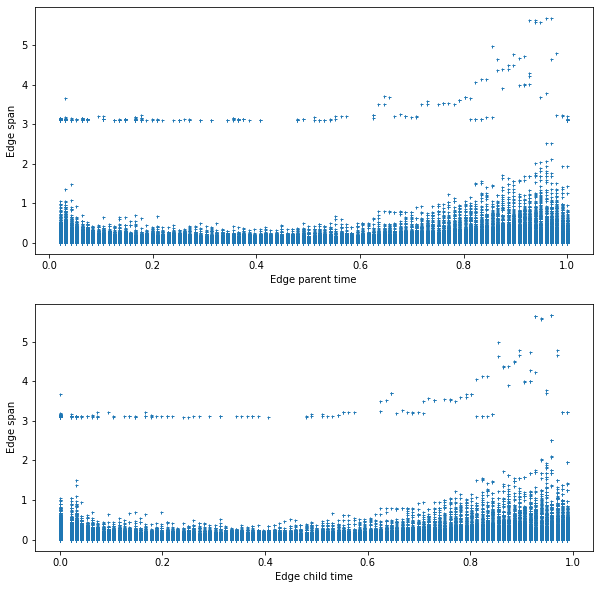

In [141]:
plt.figure(figsize=(10, 10,))

plt.subplot(211)
plt.xlabel("Edge parent time")
plt.ylabel("Edge span")
plt.plot(
    df_edges["edge_parent_times"],
    df_edges["edge_spans"],
    linestyle='none',
    marker='+',
    markersize=3,
);

plt.subplot(212)
plt.xlabel("Edge child time")
plt.ylabel("Edge span")
plt.plot(
    df_edges["edge_child_times"],
    df_edges["edge_spans"],
    linestyle="none",
    marker='+',
    markersize=3,
);

plt.show()

### Examine the correlation between node span and node time

In [149]:
node_spans = tsinfer.node_span(ts)
node_times = ts.nodes_time

if node_spans[-1] == ts.sequence_length:
    node_spans = node_spans[:-2]
    node_times = node_times[:-2]

node_spans = node_spans / 1e6

df_nodes = pd.DataFrame({
    'node_spans': node_spans,
    'node_times': node_times,
})

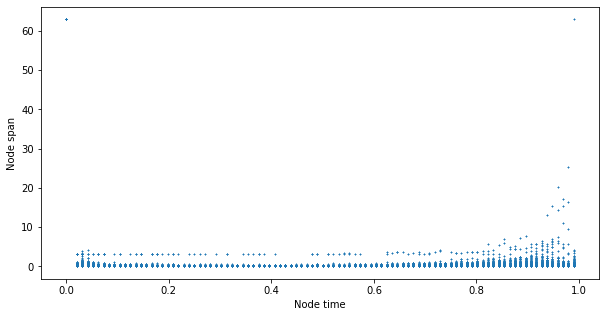

In [150]:
plt.figure(figsize=(10, 5,))
plt.xlabel("Node time")
plt.ylabel("Node span")
plt.plot(
    df_nodes["node_times"],
    df_nodes["node_spans"],
    linestyle="none",
    marker="+",
    markersize=2,
);

### Mutations per site

In [48]:
site_pos, counts = np.unique(ts.mutations_site, return_counts=True)
num_sites_with_mutation = len(site_pos)
print(f"Sites: {ts.num_sites}")
print(f"Sites with mutation: {num_sites_with_mutation}")

Sites: 1801100
Sites with mutation: 259592


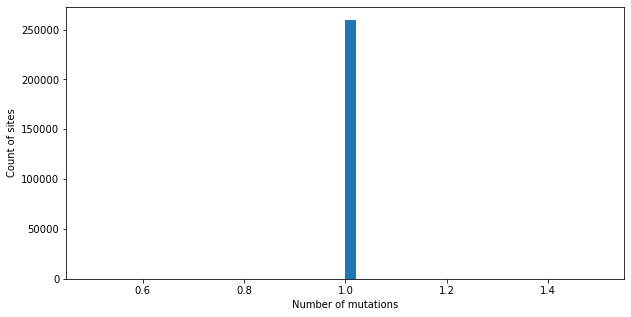

In [157]:
plt.figure(figsize=(10, 5,))
plt.ylabel("Count of sites")
plt.xlabel("Number of mutations")
plt.hist(counts, bins=50);
plt.show()

### arity

In [53]:
tree_mean_arity = np.empty(ts.num_trees)
for i, tree in enumerate(ts.trees()):
    parent_id, count = np.unique(tree.parent_array[tree.preorder()], return_counts=True)
    mean_arity = count[parent_id != tskit.NULL].mean()
    tree_mean_arity[i] = mean_arity

CPU times: user 5.61 s, sys: 12.4 ms, total: 5.62 s
Wall time: 5.63 s


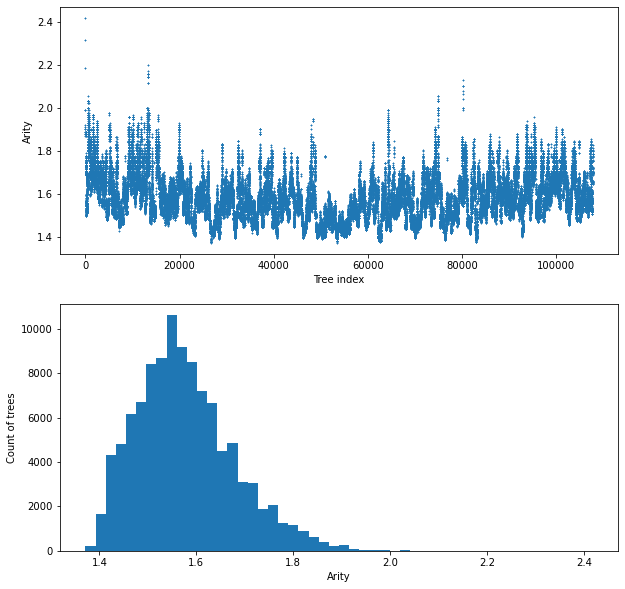

In [155]:
plt.figure(figsize=(10, 10,))

plt.subplot(211)
plt.ylabel("Arity")
plt.xlabel("Tree index")
plt.plot(
    np.arange(ts.num_trees),
    tree_mean_arity,
    linestyle="none",
    marker="+",
    markersize=2,
);

plt.subplot(212)
plt.ylabel("Count of trees")
plt.xlabel("Arity")
plt.hist(
    tree_mean_arity,
    bins=50
);

plt.show()

### Edge diffs

In [82]:
tree_edges_out = np.empty(ts.num_trees)
tree_edges_in = np.empty(ts.num_trees)
for i, (interval, edges_out, edges_in,) in enumerate(ts.edge_diffs()):
    tree_edges_out[i] = len(edges_out)
    tree_edges_in[i] = len(edges_in)

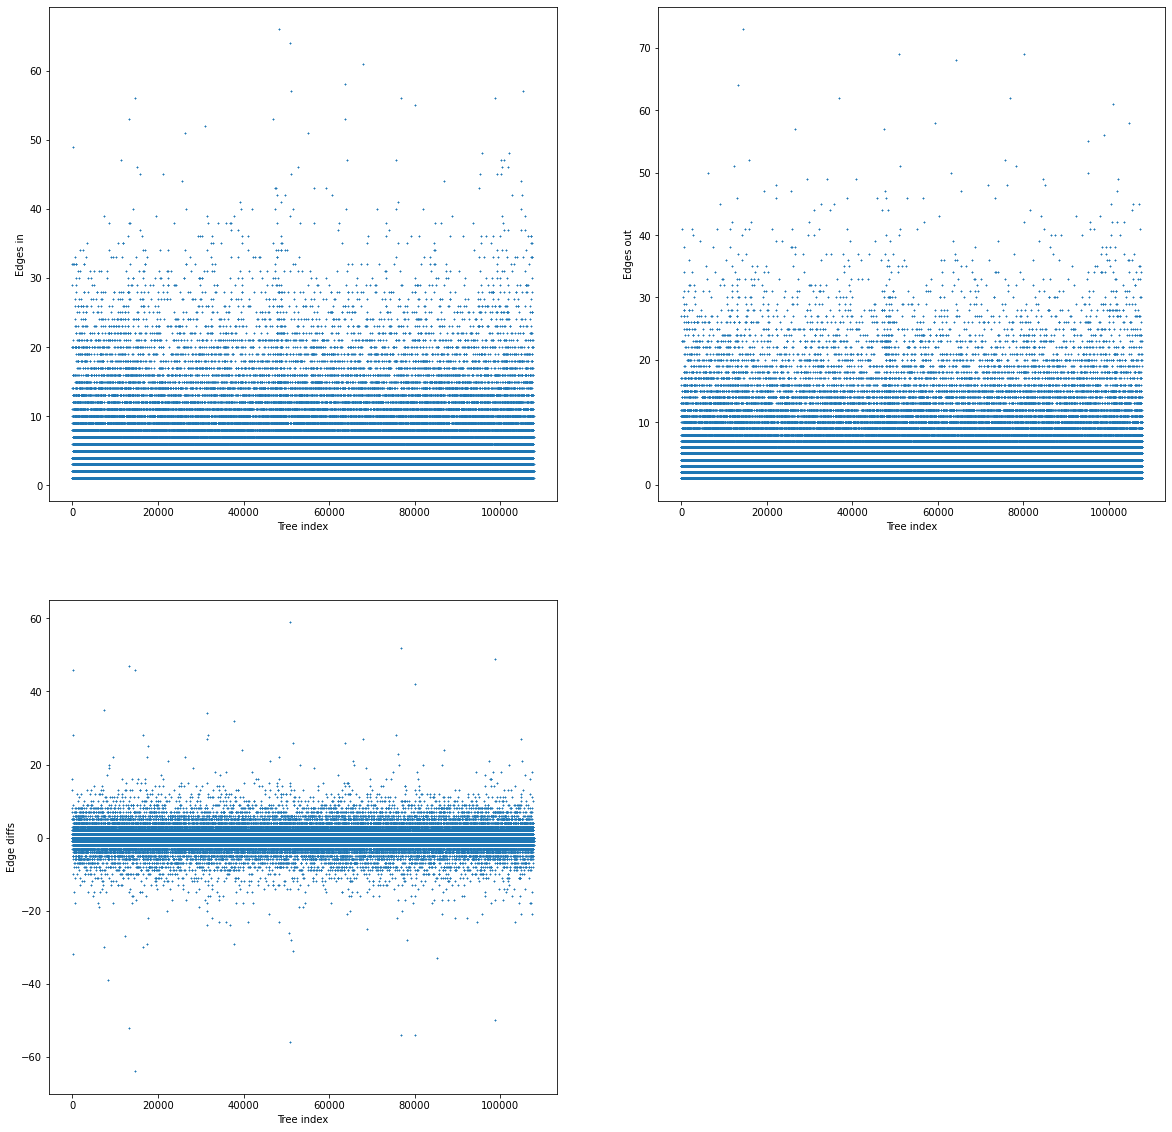

In [160]:
plt.figure(figsize=(20, 20,))

plt.subplot(221)
plt.ylabel("Edges in")
plt.xlabel("Tree index")
plt.plot(
    np.arange(1, ts.num_trees),
    tree_edges_in[1:],
    linestyle="none",
    marker="+",
    markersize=2,
);

plt.subplot(222)
plt.ylabel("Edges out")
plt.xlabel("Tree index")
plt.plot(
    np.arange(1, ts.num_trees),
    tree_edges_out[1:],
    linestyle="none",
    marker="+",
    markersize=2,
);

plt.subplot(223)
plt.ylabel("Edge diffs")
plt.xlabel("Tree index")
plt.plot(
    np.arange(1, ts.num_trees),
    tree_edges_in[1:] - tree_edges_out[1:],
    linestyle="none",
    marker="+",
    markersize=2,
);

plt.show()